In [45]:
import os
import numpy as np
import torch
import importlib
import consts
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from scipy.spatial.distance import cdist
from scipy.stats import ortho_group
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import random
from toolbox.alias_multinomial import AliasMultinomial
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score, mean_squared_error

# 重新載入 consts 以確保變數最新
importlib.reload(consts)
torch.manual_seed(consts.SEED)
np.random.seed(consts.SEED)

In [2]:
# 確保輸出目錄存在
output_dir = "newsgroup_test"
os.makedirs(output_dir, exist_ok=True)

# 下載 20 Newsgroups 資料集
categories = None
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
raw_texts_train = newsgroups_train.data
raw_texts_test = newsgroups_test.data

y_train = np.array(newsgroups_train.target)
y_test = np.array(newsgroups_test.target)

In [3]:
# 確保 raw_texts 為 list，過濾 None 和空字串
tokenized_texts_train = []
tokenized_texts_test = []
filtered_labels_train = []
filtered_labels_test = []

for doc_train, doc_test, label_train, label_test in zip(raw_texts_train, raw_texts_test, y_train, y_test):
    if isinstance(doc_train, str) and doc_train.strip(): #判斷doc是否是一個字串，並去除字串開頭與結尾的空白，確保doc是非空的字串
        tokens = word_tokenize(doc_train.lower())
        tokenized_texts_train.append(tokens)
        filtered_labels_train.append(label_train)
    
    if isinstance(doc_test, str) and doc_test.strip():
        tokens = word_tokenize(doc_test.lower())
        tokenized_texts_test.append(tokens)
        filtered_labels_test.append(label_test)

y_train = np.array(filtered_labels_train)
y_test = np.array(filtered_labels_test)

# ✅ 檢查 Tokenization 是否成功
print(f"Total Train Documents: {len(tokenized_texts_train)}")
print(f"Example Train Tokenized Texts: {tokenized_texts_train[:3]}")  # 顯示前 3 個 Tokenized 結果
print(f"Train Labeel: ", len(y_train))
print(f"Total Test Documents: {len(tokenized_texts_test)}")
print(f"Example Test Tokenized Texts: {tokenized_texts_test[:3]}")  # 顯示前 3 個 Tokenized 結果
print(f"Test Labeel: ", len(y_test))

Total Train Documents: 7328
Example Train Tokenized Texts: [['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', '.', 'it', 'was', 'a', '2-door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s', '.', 'it', 'was', 'called', 'a', 'bricklin', '.', 'the', 'doors', 'were', 'really', 'small', '.', 'in', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'this', 'is', 'all', 'i', 'know', '.', 'if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs', ',', 'years', 'of', 'production', ',', 'where', 'this', 'car', 'is', 'made', ',', 'history', ',', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', ',', 'please', 'e-mail', '.'], ['a', 'fair', 'number', 'of', 'brave', 'souls', 'who', 'upgraded', 'their', 'si', 'clock', 'oscillator', 'have', 'shared', 'their'

In [6]:
# ✅ 確保 NLTK 停用詞 (stopwords) 可用
nltk.download("stopwords")

# 停用詞列表 (例如 "the", "to", "and" 這些常見詞)
stop_words = set(stopwords.words("english"))

# 設定最大詞彙數量
MAX_VOCAB_SIZE = 5000

# **過濾標點符號、數字、停用詞**
cleaned_texts_train = []
for doc in tokenized_texts_train:
    cleaned_doc = [word.lower() for word in doc if word.isalpha() and word.lower() not in stop_words]
    cleaned_texts_train.append(cleaned_doc)

# 計算詞頻
word_counts = Counter(word for doc in cleaned_texts_train for word in doc)

# **只保留前 5000 個最常見的詞**
most_common_words = word_counts.most_common(MAX_VOCAB_SIZE)

# **建立詞彙表**
vocab = {word: idx for idx, (word, _) in enumerate(most_common_words)}

# ✅ 打印 vocab 內部示例
print("詞彙表大小:", len(vocab))  # 應該 <= 5000
print("前 10 個詞:", list(vocab.items())[:50])  # 顯示前 10 個詞

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HungLin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


詞彙表大小: 5000
前 10 個詞: [('would', 0), ('x', 1), ('one', 2), ('max', 3), ('people', 4), ('like', 5), ('get', 6), ('know', 7), ('q', 8), ('also', 9), ('use', 10), ('r', 11), ('think', 12), ('g', 13), ('could', 14), ('time', 15), ('new', 16), ('good', 17), ('p', 18), ('may', 19), ('well', 20), ('even', 21), ('see', 22), ('first', 23), ('much', 24), ('two', 25), ('many', 26), ('us', 27), ('system', 28), ('file', 29), ('make', 30), ('way', 31), ('n', 32), ('used', 33), ('say', 34), ('right', 35), ('want', 36), ('said', 37), ('god', 38), ('work', 39), ('anyone', 40), ('c', 41), ('need', 42), ('since', 43), ('please', 44), ('something', 45), ('go', 46), ('b', 47), ('w', 48), ('program', 49)]


In [7]:
def build_bow_matrix(tokenized_texts, vocab):
    """
    將 tokenized_texts 轉換為 BoW 特徵矩陣。

    Parameters:
    - tokenized_texts: List[List[str]], 每篇文件的詞彙列表
    - vocab: Dict[str, int], 詞彙表，將單詞對應到欄位 index（例如 {"apple": 0, "banana": 1, ...}）

    Returns:
    - X_bow: np.ndarray, 形狀為 (num_docs, vocab_size)
    """
    vocab_size = len(vocab)
    num_docs = len(tokenized_texts)
    X_bow = np.zeros((num_docs, vocab_size), dtype=np.float32)

    for doc_idx, tokens in enumerate(tokenized_texts):
        for token in tokens:
            if token in vocab:
                token_idx = vocab[token]
                X_bow[doc_idx, token_idx] += 1  # 可改成 += tf-idf 等

    return X_bow

In [8]:
# 假設你已經有：
# - tokenized_texts: 已分詞的文件清單
# - vocab: 透過 word_counts 建立好的 {word: index} 字典

X_train = build_bow_matrix(tokenized_texts_train, vocab)
print("X_train shape:", X_train.shape)

X_train shape: (7328, 5000)


In [9]:
X_test = build_bow_matrix(tokenized_texts_test, vocab)
print("X_test shape:", X_test.shape)

X_test shape: (7317, 5000)


In [10]:
# ✅ 產生 doc_lens
doc_lens_train = np.sum(X_train, axis=1)
doc_lens_test = np.sum(X_test, axis=1)

In [11]:
# ✅ 轉換為 PyTorch Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [12]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([7328, 5000])
torch.Size([7317, 5000])
torch.Size([7328])
torch.Size([7317])


In [13]:
print("Max y_train:", y_train_tensor.max().item())
print("Min y_train:", y_train_tensor.min().item())
print("Unique labels:", torch.unique(y_train_tensor))
print("self.num_classes:", len(np.unique(y_train_tensor.cpu().numpy())))

Max y_train: 19.0
Min y_train: 0.0
Unique labels: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.], device='cuda:0')
self.num_classes: 20


In [14]:
print("tokenized_texts 長度:", len(tokenized_texts_train))
print("labels 長度:", len(y_train))

tokenized_texts 長度: 7328
labels 長度: 7328


In [18]:
# ✅ 產生 doc_windows（上下文窗口）
def get_windows(tokenized_texts, vocab, labels, window_size=5, pad_token_idx=0):
    assert window_size % 2 == 1
    assert len(tokenized_texts) == len(labels)
    half_window = window_size // 2  # 左右各取 `half_window` 個詞
    context_size = 2 * half_window
    total_len = 1 + 1 + context_size

    windows = []

    for doc_idx, tokens in enumerate(tokenized_texts):
        indexed_tokens = [vocab[word] for word in tokens if word in vocab]  # 將文本轉換為索引
        
        if len(indexed_tokens) >= 2:  # 確保至少有兩個詞
            for i in range(len(indexed_tokens)):
                pivot = indexed_tokens[i]  # 中心詞
                
                # 計算前後詞的範圍，確保不超出文本範圍
                start_idx = max(0, i - half_window)  # 確保索引不低於 0
                end_idx = min(len(indexed_tokens), i + half_window + 1)  # 確保索引不超過最大範圍
                
                context = indexed_tokens[start_idx:i] + indexed_tokens[i + 1:end_idx]  # 前後取詞

                while len(context) < context_size:
                    context.append(pad_token_idx)

                label = labels[doc_idx]
                    
                windows.append([doc_idx, pivot] + context + [label])  # 輸出格式：[doc_idx, pivot_word, context_word1, ..., label]

    return np.array(windows, dtype=np.int64)

doc_windows = get_windows(tokenized_texts_train, vocab, labels=y_train, window_size=5)

In [21]:
print(doc_windows[:5])

[[   0 1017   40   14    0    0    7]
 [   0   40 1017   14  155    0    7]
 [   0   14 1017   40  155  358    7]
 [   0  155   40   14  358  136    7]
 [   0  358   14  155  136 2155    7]]


In [22]:
# 建立 vocab 的反向字典
index_to_word = {idx: word for word, idx in vocab.items()}

# 轉換數字回詞
def decode_window(window):
    doc_idx = window[0]
    pivot_word = index_to_word[window[1]] if window[1] in index_to_word else "<UNK>"
    context_words = [index_to_word[idx] if idx in index_to_word else "<UNK>" for idx in window[2:]]
    return [doc_idx, pivot_word] + context_words

# 測試解碼
decoded_windows = [decode_window(window) for window in doc_windows[:5]]
for w in decoded_windows:
    print(w)

[0, 'wondering', 'anyone', 'could', 'would', 'would', 'know']
[0, 'anyone', 'wondering', 'could', 'car', 'would', 'know']
[0, 'could', 'wondering', 'anyone', 'car', 'saw', 'know']
[0, 'car', 'anyone', 'could', 'saw', 'day', 'know']
[0, 'saw', 'could', 'car', 'day', 'sports', 'know']


In [23]:
def set_seed(seed=9527):
    """
    設置隨機種子，確保結果可重現。
    
    Parameters:
    - seed (int): 隨機種子數值
    """
    random.seed(seed)  # 設置 Python 內建 random 庫的種子
    np.random.seed(seed)  # 設置 NumPy 的隨機種子
    torch.manual_seed(seed)  # 設置 PyTorch 的隨機種子
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設置 GPU 隨機種子
        torch.cuda.manual_seed_all(seed)  # 設置所有 GPU 的隨機種子
        torch.backends.cudnn.deterministic = True  # 確保 cuDNN 生成的結果可重現
        torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 自適應優化，確保可重現性

In [24]:
# ✅ 自訂 PyTorch Dataset
class DocWindowsDataset(Dataset):
    def __init__(self, windows):
        self.data = windows

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

In [63]:
# ✅ 概念挖掘模型
class GuidedDiverseConceptMiner(nn.Module):
    def __init__(self, vocab, vocab_size, nconcepts=10, embed_dim=50, nnegs=15, lam=100.0, rho=100.0, eta=1.0, theta=None, bow_train=None, y_train=None, doc_windows=None, word_counts=None, seed=9527):
        super(GuidedDiverseConceptMiner, self).__init__()
        set_seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.vocab_dict = vocab
        self.vocab = list(vocab.keys())
        self.nconcepts = nconcepts
        self.nnegs = nnegs
        vocab_size = len(self.vocab)

        self.lam = lam
        self.rho = rho
        self.eta = eta
        self.alpha = 1.0 / nconcepts
        self.embedding_i = nn.Embedding(vocab_size, embed_dim).to(self.device)
        self.embedding_t = nn.Parameter(
            torch.FloatTensor(ortho_group.rvs(embed_dim)[0:nconcepts]).to(self.device),
            requires_grad=True
        )
        self.doc_concept_weights = nn.Embedding(bow_train.shape[0], nconcepts).to(self.device)
        self.docweights = torch.ones(bow_train.shape[0], dtype=torch.float32, device=self.device)
        self.train_dataset = DocWindowsDataset(doc_windows)
        self.linear = nn.Linear(nconcepts, 1).to(self.device)
        self.bow_train = torch.tensor(bow_train, dtype=torch.float32, requires_grad=False, device=self.device)

        self.num_classes = len(np.unique(np.concatenate([y_train, y_test])))
        self.theta = nn.Parameter(torch.FloatTensor(nconcepts + 1, self.num_classes)).to(self.device) #目前沒有explanary variables所以沒有其他case
        torch.nn.init.normal_(self.theta)

        self.embedding_i.weight.requires_grad = True
        self.embedding_t.requires_grad = True

        #negative sampling的權重
        word_freq_array = np.array([word_counts.get(word, 1) for word in vocab.keys()])
        wf = np.power(word_freq_array, 0.75)
        wf = wf / np.sum(wf)
        self.weights = torch.tensor(wf, dtype=torch.float32, requires_grad=False, device=device)
        
        self.dropout1 = nn.Dropout(consts.PIVOTS_DROPOUT)
        self.dropout2 = nn.Dropout(consts.DOC_VECS_DROPOUT)
        self.multinomial = AliasMultinomial(wf, self.device)

    def forward(self, doc, target, contexts, labels):
        batch_size = contexts.size(0)
        window_size = contexts.size(1)
        #用文件長度重新調整loss權重
        w = autograd.Variable(self.docweights[doc.data]).to(self.device)
        w /= w.sum()
        w *= w.size(0)

        doc_concept_probs = F.softmax(self.doc_concept_weights(doc), dim=1).to(self.device) #計算每個文件與不同概念的關聯程度
        concept_embeddings = self.embedding_t.expand(batch_size, -1, -1) #把embedding_t(概念向量)展開，讓它的形狀從(nnconcepts, embed_dim)，變成(batch_size, nnconcepts, embed_dim)，為了下一步torch.bmm的計算
        doc_vector = torch.bmm(doc_concept_probs.unsqueeze(1), concept_embeddings).squeeze(1) #doc_vector，代表每個文件的最終向量表示，用來計算概念權重，影響預測結果。(batch_size, 1, nnconcepts) x (batch_size, nnconcepts, embed_dim) = (batch_size, 1, embed_dim)
        
        #sample negative word indices for negative sampling loss; approximation by sampling from the whole vocab
        nwords = self.multinomial.draw(batch_size * window_size * self.nnegs)
        nwords = autograd.Variable(nwords).view(batch_size, window_size * self.nnegs)

        #計算word vectors
        ivectors = self.dropout1(self.embedding_i(target)) #目標詞向量
        ovectors = self.embedding_i(contexts) #上下文詞向量
        nvectors = self.embedding_i(nwords).neg() #負樣本詞向量

        context_vectors = doc_vector + ivectors
        context_vectors = context_vectors.unsqueeze(2)

        #計算negative sampling loss
        oloss = torch.bmm(ovectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        nloss = torch.bmm(nvectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        negative_sampling_loss = (oloss + nloss).neg()
        negative_sampling_loss *= w
        negative_sampling_loss = negative_sampling_loss.mean()

        # compose dirichlet loss
        doc_concept_probs = doc_concept_probs.squeeze(dim=1)  # (batches, T)
        doc_concept_probs = doc_concept_probs.clamp(min=consts.EPS)
        dirichlet_loss = doc_concept_probs.log().sum(1)  # (batches, 1)
        dirichlet_loss *= self.lam * (1.0 - self.alpha)
        dirichlet_loss *= w  # downweight loss for each document
        dirichlet_loss = dirichlet_loss.mean()  # mean over the entire batch

        # compose diversity loss
        #   1. First compute \sum_i \sum_j log(sigmoid(T_i, T_j))
        #   2. Then compute \sum_i log(sigmoid(T_i, T_i))
        #   3. Loss = (\sum_i \sum_j log(sigmoid(T_i, T_j)) - \sum_i log(sigmoid(T_i, T_i)) )
        #           = \sum_i \sum_{j > i} log(sigmoid(T_i, T_j))
        div_loss = torch.mm(self.embedding_t,
                            torch.t(self.embedding_t)).sigmoid().clamp(min=consts.EPS).log().sum() \
                    - (self.embedding_t * self.embedding_t).sigmoid().clamp(min=consts.EPS).log().sum()
        div_loss /= 2.0  # taking care of duplicate pairs T_i, T_j and T_j, T_i
        div_loss = div_loss.repeat(batch_size)
        div_loss *= w  # downweight by document lengths
        div_loss *= self.eta
        div_loss = div_loss.mean()  # mean over the entire batch
        
        #從這裡開始寫pred的loss
        ones = torch.ones((batch_size, 1)).to(self.device)
        doc_concept_probs = torch.cat((ones, doc_concept_probs), dim=1)

        # expand doc_concept_probs vector with explanatory variables 還沒有寫explanatory variables，待更新
        #if self.expvars_train is not None:
        #    doc_concept_probs = torch.cat((doc_concept_probs, self.expvars_train[doc, :]),
        #                                    dim=1)
        # compose prediction loss
        # [batch_size] = torch.matmul([batch_size, nconcepts], [nconcepts])
        # pred_weight = torch.matmul(doc_concept_probs.unsqueeze(0), self.theta).squeeze(0)
        # print(doc_concept_probs.shape)
        # print(self.theta.shape)
        pred_weight = torch.matmul(doc_concept_probs, self.theta)
        # print(pred_weight)
        # print(labels)

        pred_loss = F.cross_entropy(pred_weight, labels.long(), reduction = 'none')

        pred_loss *= self.rho
        pred_loss = pred_loss.mean()
        """
            計算預測損失 (Prediction Loss)
            binary_cross_entropy_with_logits適用於二元分類
            cross_entropy適用於多分類
            mse_loss適用於回歸
            公式8
        """
        return pred_loss, negative_sampling_loss, dirichlet_loss, div_loss

    def fit(self, lr=0.01, nepochs=10, batch_size=100):
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(nepochs):
            total_loss = 0.0
            total_pred_loss = 0.0
            total_neg_sampling_loss = 0.0
            total_dirichlet_loss = 0.0
            total_div_loss = 0.0
            num_batches = 0

            self.train()
            for batch in train_dataloader:
                batch = batch.long().to(self.device)
                doc, target, contexts, label = batch[:, 0], batch[:, 1], batch[:, 2:], batch[:, -1].float()
                pred_loss, neg_sampling_loss, dirichlet_loss, div_loss = self(doc.to(self.device), target.to(self.device), contexts.to(self.device), label.to(self.device))
                loss = neg_sampling_loss + dirichlet_loss + div_loss + pred_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_neg_sampling_loss += neg_sampling_loss.item()
                total_dirichlet_loss += dirichlet_loss.item()
                total_div_loss += div_loss.item()
                total_pred_loss += pred_loss.item()
                num_batches += 1
                
            avg_loss = total_loss / num_batches
            avg_neg_sampling_loss = total_neg_sampling_loss / num_batches
            avg_dirichlet_loss = total_dirichlet_loss / num_batches
            avg_div_loss = total_div_loss / num_batches
            avg_pred_loss = total_pred_loss / num_batches
            print(f"Epoch {epoch + 1}/{nepochs} - Total Loss: {avg_loss:.4f}, "
              f"Neg Sampling Loss: {avg_neg_sampling_loss:.4f}, "
              f"Dirichlet Loss: {avg_dirichlet_loss:.4f}, "
              f"Diversity Loss: {avg_div_loss:.4f}",
              f"Prediction Loss: {avg_dirichlet_loss:.4f}")

    def visualize(self, top_k=10, concept_dist='dot'):
        """
        可視化每個概念的關鍵詞詞雲。

        Parameters:
        - top_k: 每個概念取前 K 個相關詞
        - concept_dist: 計算概念與詞語之間的距離 ('dot', 'cosine', 'euclidean' 等)
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white')

        # 取得每個概念的前 K 個關鍵詞
        concept_words_list = self.get_concept_words(top_k=top_k, concept_dist=concept_dist)

        for i, concept_words in enumerate(concept_words_list):
            # 為詞雲創建詞頻字典（每個詞的頻率設為固定值，確保詞雲可視化）
            concept_word_freqs = {word: 1.0 for word in concept_words}

            # 生成詞雲
            wc = wordcloud.generate_from_frequencies(concept_word_freqs)

            # 顯示詞雲
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Concept {i+1}")
            plt.show()
        
    def get_concept_words(self, top_k=10, concept_dist='dot'):
        """
        獲取每個概念最相關的詞彙。
        
        Parameters:
        - top_k: 取前 K 個相關的詞
        - concept_dist: 計算概念與詞語之間距離的方法 (可選: 'dot', 'cosine', 'euclidean' 等)
        """
        concept_embed = self.embedding_t.data.cpu().numpy()
        word_embed = self.embedding_i.weight.data.cpu().numpy()

        if concept_dist == 'dot':
            dist = -np.matmul(concept_embed, np.transpose(word_embed, (1, 0)))
        else:
            dist = cdist(concept_embed, word_embed, metric=concept_dist)

        nearest_word_idxs = np.argsort(dist, axis=1)[:, :top_k]  # 找到最相關的 top_k 個詞

        inv_vocab = {idx: word for word, idx in self.vocab_dict.items()}

        concepts = []
        for j in range(self.nconcepts):
            nearest_words = [self.vocab[i] for i in nearest_word_idxs[j] if i in inv_vocab]
            concepts.append(nearest_words)

        return concepts
    
    def calculate_auc(self, split, X, y, expvars): #根據模型種類計算AUC或MSE
        """
        split : 指示dataset是train或test
        x : 特徵矩陣(bag-of-words或其他表示)
        y : 標籤(真實值)
        expvars : 額外的變數(在predict_proba中使用)
        """
        y_pred = self.predict_proba(X, expvars).cpu().detach().numpy()
        """
        self.predict_proba(X, expvars)：模型對輸入 X 進行推理，返回預測機率。
        .cpu().detach().numpy()：將 PyTorch tensor 轉換成 NumPy 陣列，因為 roc_auc_score 需要 NumPy 格式的輸入。
        """
        y = np.asarray(y).astype(int) #將 y 轉換為 NumPy 陣列並確保是整數類型。
        
        num_classes = len(np.unique(y)) #統計有多少個不同的類別。
        
        if num_classes > 1:  
            
            y_pred_normalized = y_pred / y_pred.sum(axis=1, keepdims=True) #使 y_pred 機率總和為 1，確保是正規化的機率分佈。
            auc = roc_auc_score(y, y_pred_normalized, multi_class='ovr') #計算「一對其餘 (OvR, One-vs-Rest)」的 AUC。
            return auc
        else:
            #in case only one class is present
            #self.logger.warning("Only one class present in true labels. ROC AUC score is not defined in that case.")
            return None
    
    def predict_proba(self, count_matrix, expvars=None): #對給定的 count_matrix（詞頻矩陣或 bag-of-words 表示）進行推理，並返回預測機率（probability）。
        """
        count_matrix: 文檔的詞頻矩陣（Bag-of-Words 或類似的特徵表示）。
        expvars: 額外的變數（可能是額外的輔助特徵，如元數據、外部變量等）。
        """
        with torch.no_grad(): #關閉梯度計算，提高效率並節省記憶體
            batch_size = count_matrix.size(0) #取得批次大小，接著計算文件概念權重(doc_concept_weights)
            doc_indices = torch.arange(count_matrix.size(0), device=self.device)
            doc_concept_weights = self.doc_concept_weights(doc_indices)
            doc_concept_probs = F.softmax(doc_concept_weights, dim=1)  # convert to probabilities
            ones = torch.ones((batch_size, 1)).to(self.device)
            doc_concept_probs = torch.cat((ones, doc_concept_probs), dim=1)
            """
            加入一個恆等概念 (bias term)
            為什麼要加 ones?
                這可能是為了表示一個固定的 偏置項 (bias term)，類似於線性模型中的截距項 (intercept)。
                torch.cat((ones, doc_concept_probs), dim=1)：將 ones 附加到概念機率矩陣的第一列。
            """

            if expvars is not None: #如果有額外變數 (expvars)，將其拼接
                doc_concept_probs = torch.cat((doc_concept_probs, expvars), dim=1)

            pred_weight = torch.matmul(doc_concept_probs, self.theta) #計算預測加權權重 (pred_weight)，代表預測的未標準化分數（logits）。
            pred_proba = pred_weight.sigmoid() #透過 Sigmoid 轉換為機率
        return pred_proba

In [64]:
# ✅ 訓練模型
gdcm = GuidedDiverseConceptMiner(
    vocab=vocab,
    vocab_size=len(vocab),
    bow_train=X_train_tensor.cpu().numpy(),
    y_train=y_train_tensor.cpu().numpy(),
    doc_windows=doc_windows,
    word_counts=word_counts,
    seed=9527
)

In [65]:
gdcm.fit(nepochs=5, batch_size=100)

Epoch 1/5 - Total Loss: -9614.2230, Neg Sampling Loss: 33.9074, Dirichlet Loss: -9352.0418, Diversity Loss: -628.3039 Prediction Loss: -9352.0418
Epoch 2/5 - Total Loss: -14780.3912, Neg Sampling Loss: 19.5557, Dirichlet Loss: -14496.2835, Diversity Loss: -641.9079 Prediction Loss: -14496.2835
Epoch 3/5 - Total Loss: -16039.2464, Neg Sampling Loss: 19.5343, Dirichlet Loss: -15752.5542, Diversity Loss: -641.8930 Prediction Loss: -15752.5542
Epoch 4/5 - Total Loss: -16533.0053, Neg Sampling Loss: 19.5637, Dirichlet Loss: -16244.0977, Diversity Loss: -641.8848 Prediction Loss: -16244.0977
Epoch 5/5 - Total Loss: -16783.8179, Neg Sampling Loss: 19.5856, Dirichlet Loss: -16494.3121, Diversity Loss: -641.8899 Prediction Loss: -16494.3121


In [66]:
# 查看詞彙表的前 50 個單詞
print("Vocabulary sample:", list(vocab.items())[:50])

# 檢查概念關鍵詞的選擇
concepts = gdcm.get_concept_words(top_k=10, concept_dist="cosine")
for i, concept_words in enumerate(concepts):
    print(f'Concept {i+1}: {concept_words}')

Vocabulary sample: [('would', 0), ('x', 1), ('one', 2), ('max', 3), ('people', 4), ('like', 5), ('get', 6), ('know', 7), ('q', 8), ('also', 9), ('use', 10), ('r', 11), ('think', 12), ('g', 13), ('could', 14), ('time', 15), ('new', 16), ('good', 17), ('p', 18), ('may', 19), ('well', 20), ('even', 21), ('see', 22), ('first', 23), ('much', 24), ('two', 25), ('many', 26), ('us', 27), ('system', 28), ('file', 29), ('make', 30), ('way', 31), ('n', 32), ('used', 33), ('say', 34), ('right', 35), ('want', 36), ('said', 37), ('god', 38), ('work', 39), ('anyone', 40), ('c', 41), ('need', 42), ('since', 43), ('please', 44), ('something', 45), ('go', 46), ('b', 47), ('w', 48), ('program', 49)]
Concept 1: ['tx', 'th', 'telecommunications', 'estimate', 'subjective', 'mouth', 'violent', 'kidney', 'stock', 'steal']
Concept 2: ['boots', 'adaptec', 'maintaining', 'qs', 'governments', 'landing', 'poster', 'jumped', 'gc', 'electric']
Concept 3: ['responded', 'girls', 'maintained', 'detect', 'husband', 'ink

In [67]:
test_auc_or_mse = gdcm.calculate_auc("Test", X_test_tensor, y_test, expvars=None)

In [68]:
print(test_auc_or_mse)

0.49555005082318654


In [69]:
train_auc_or_mse = gdcm.calculate_auc("Test", X_train_tensor, y_train, expvars=None)

In [70]:
print(train_auc_or_mse)

0.6218854396722415


In [36]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def compute_coherence(concept_words_list, texts, method="c_v"):
    """
    計算概念內的詞彙 Coherence。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念內的關鍵詞（`get_concept_words()` 提供）
    - texts: List[List[str]]，原始文本分詞（用於計算 Coherence）
    - method: "c_v", "c_uci", "c_npmi"（選擇不同 Coherence 方法）

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_scores = []
    for concept_words in concept_words_list:
        cm = CoherenceModel(topics=[concept_words], texts=texts, dictionary=dictionary, coherence=method)
        coherence_scores.append(cm.get_coherence())
    
    return coherence_scores

In [37]:
concept_words_list = gdcm.get_concept_words(top_k=10, concept_dist="cosine")  # 取得概念內的詞
texts = [text.split() for text in newsgroups_train.data]  # 轉換文本為 token
coherence_scores = compute_coherence(concept_words_list, texts, method="c_npmi")

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Coherence: {score:.4f}")

Concept 1 Coherence: -0.3701
Concept 2 Coherence: -0.3644
Concept 3 Coherence: -0.3315
Concept 4 Coherence: -0.2829
Concept 5 Coherence: -0.3443
Concept 6 Coherence: -0.3310
Concept 7 Coherence: -0.3017
Concept 8 Coherence: -0.3046
Concept 9 Coherence: -0.3336
Concept 10 Coherence: -0.2894


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_coherence(concept_words_list, word_vectors):
    """
    計算每個概念內詞向量的平均餘弦相似度，評估內聚性。

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - word_vectors: dict，詞向量字典，例如 Word2Vec/GloVe/BERT 的 embeddings

    Returns:
    - coherence_scores: List[float]，每個概念的平均相似度
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        vectors = [word_vectors[word] for word in concept_words if word in word_vectors]
        
        if len(vectors) < 2:
            coherence_scores.append(0)  # 如果概念內少於 2 個詞，設為 0
            continue
        
        similarity_matrix = cosine_similarity(vectors)
        avg_similarity = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean()
        coherence_scores.append(avg_similarity)
    
    return coherence_scores

In [39]:
# 獲取詞向量
word_vectors = {word: gdcm.embedding_i.weight.data.cpu().numpy()[idx] for idx, word in enumerate(vocab)}

# 計算 Coherence
cosine_coherence_scores = compute_cosine_coherence(concept_words_list, word_vectors)

for i, score in enumerate(cosine_coherence_scores):
    print(f"Concept {i+1} Cosine Coherence: {score:.4f}")

Concept 1 Cosine Coherence: 0.1875
Concept 2 Cosine Coherence: 0.1650
Concept 3 Cosine Coherence: 0.1554
Concept 4 Cosine Coherence: 0.1475
Concept 5 Cosine Coherence: 0.1510
Concept 6 Cosine Coherence: 0.1349
Concept 7 Cosine Coherence: 0.1903
Concept 8 Cosine Coherence: 0.1563
Concept 9 Cosine Coherence: 0.1735
Concept 10 Cosine Coherence: 0.1320


In [40]:
from itertools import combinations

def compute_jaccard_coherence(concept_words_list, texts):
    """
    計算 Jaccard Similarity 作為 Coherence 分數。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞
    
    Returns:
    - coherence_scores: List[float]，每個概念的 Jaccard 相似度平均值
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        pairs = list(combinations(concept_words, 2))  # 生成所有單詞對
        
        jaccard_scores = []
        for w1, w2 in pairs:
            docs_w1 = {i for i, doc in enumerate(texts) if w1 in doc}
            docs_w2 = {i for i, doc in enumerate(texts) if w2 in doc}
            
            intersection = len(docs_w1 & docs_w2)
            union = len(docs_w1 | docs_w2)
            
            if union == 0:
                jaccard_scores.append(0)
            else:
                jaccard_scores.append(intersection / union)
        
        coherence_scores.append(np.mean(jaccard_scores) if jaccard_scores else 0)
    
    return coherence_scores

In [41]:
jaccard_coherence_scores = compute_jaccard_coherence(concept_words_list, texts)

for i, score in enumerate(jaccard_coherence_scores):
    print(f"Concept {i+1} Jaccard Coherence: {score:.4f}")

Concept 1 Jaccard Coherence: 0.0068
Concept 2 Jaccard Coherence: 0.0004
Concept 3 Jaccard Coherence: 0.0034
Concept 4 Jaccard Coherence: 0.0101
Concept 5 Jaccard Coherence: 0.0057
Concept 6 Jaccard Coherence: 0.0064
Concept 7 Jaccard Coherence: 0.0015
Concept 8 Jaccard Coherence: 0.0041
Concept 9 Jaccard Coherence: 0.0032
Concept 10 Jaccard Coherence: 0.0010


In [42]:
from collections import defaultdict
import numpy as np

def compute_mimno_coherence(concept_words_list, texts):
    """
    Mimno 和 McCallum (2008) Coherence 計算方式，避免 division by zero 錯誤

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞後的列表

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    # 記錄每個詞在哪些文件中出現
    doc_word_counts = defaultdict(set)  # 用 set 存儲詞的文件索引
    for i, text in enumerate(texts):
        for word in set(text):  # 轉換為 set，避免重複計數
            doc_word_counts[word].add(i)

    coherence_scores = []
    for concept_words in concept_words_list:
        pairs = [(w1, w2) for i, w1 in enumerate(concept_words) for w2 in concept_words[i+1:]]
        coherence = []
        for w1, w2 in pairs:
            D_w1 = len(doc_word_counts[w1])  # 包含 w1 的文件數量
            D_w1_w2 = len(doc_word_counts[w1] & doc_word_counts[w2])  # 同時包含 w1 和 w2 的文件數量
            
            # **防止 division by zero**
            if D_w1 == 0:
                continue  # 如果 w1 不在任何文檔中，跳過這個詞對
            
            score = np.log((D_w1_w2 + 1) / (D_w1 + 1e-10))  # 加一個小的數值避免除零錯誤
            coherence.append(score)

        coherence_scores.append(np.mean(coherence) if coherence else -np.inf)  # 避免空列表報錯

    return coherence_scores

In [43]:
mimno_coherence_scores = compute_mimno_coherence(concept_words_list, texts)

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Mimno Coherence: {score:.4f}")

Concept 1 Mimno Coherence: -0.3701
Concept 2 Mimno Coherence: -0.3644
Concept 3 Mimno Coherence: -0.3315
Concept 4 Mimno Coherence: -0.2829
Concept 5 Mimno Coherence: -0.3443
Concept 6 Mimno Coherence: -0.3310
Concept 7 Mimno Coherence: -0.3017
Concept 8 Mimno Coherence: -0.3046
Concept 9 Mimno Coherence: -0.3336
Concept 10 Mimno Coherence: -0.2894


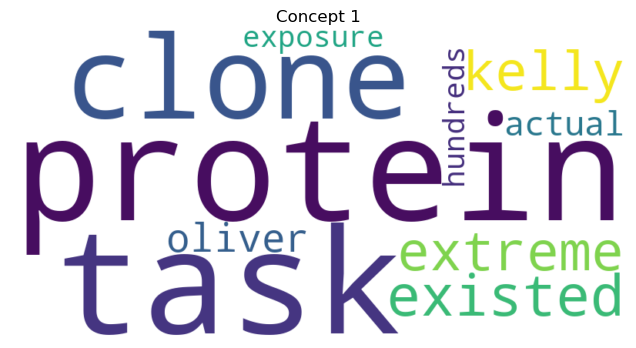

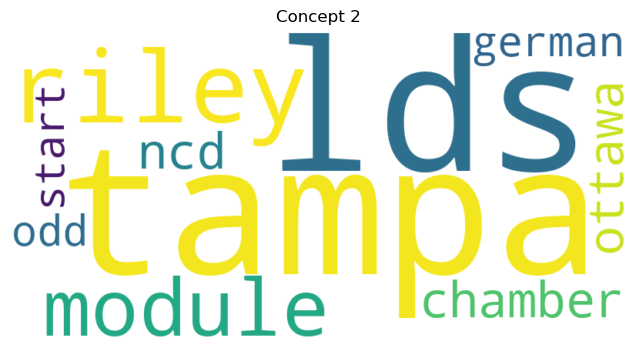

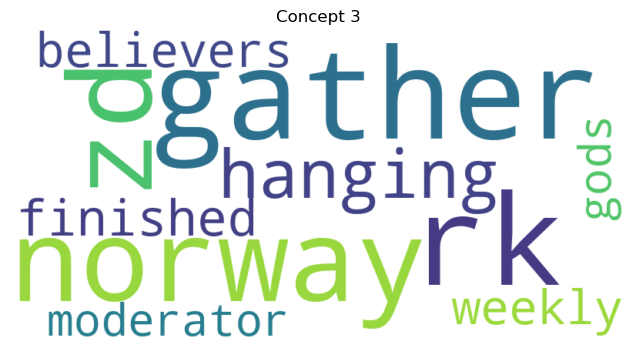

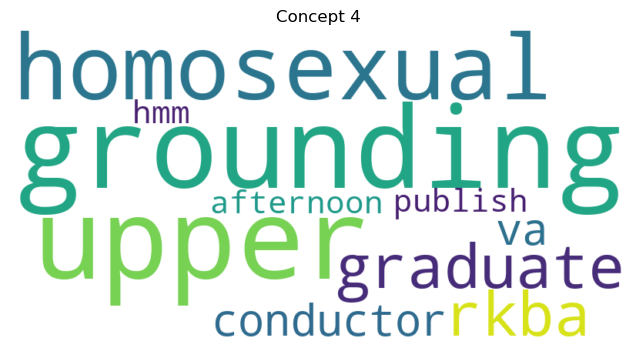

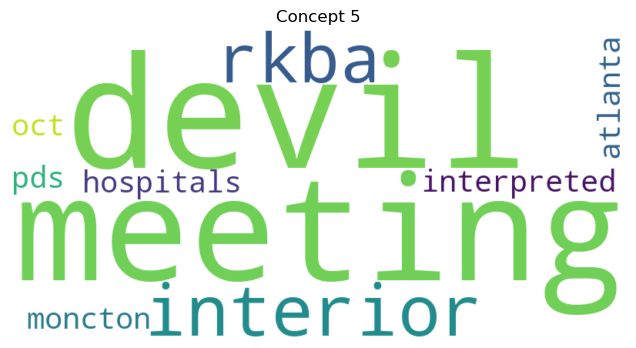

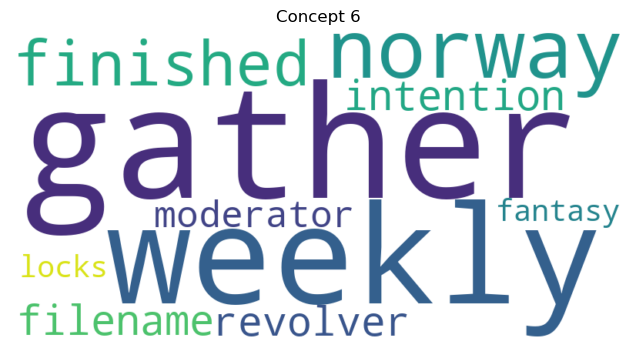

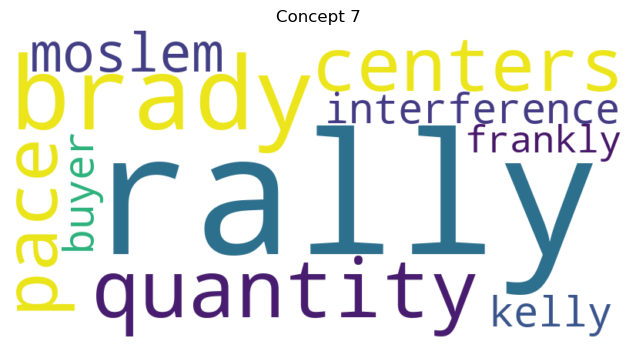

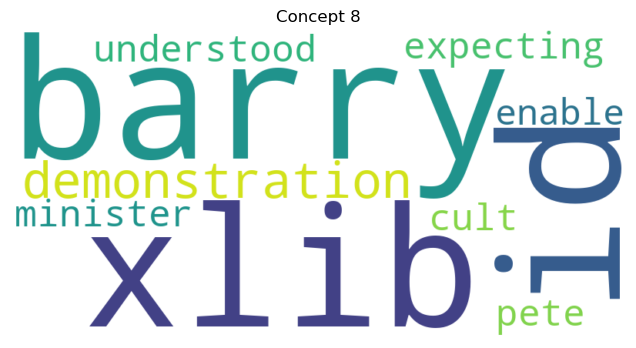

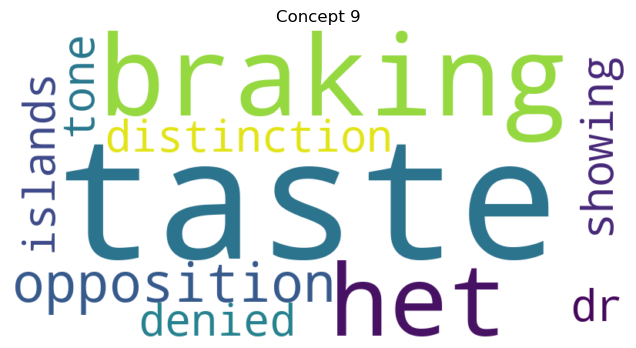

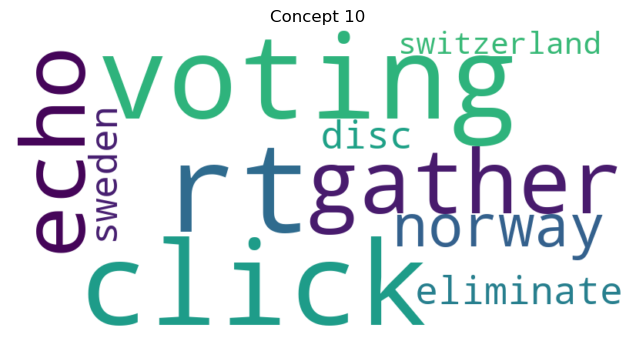

In [44]:
# ✅ 產生概念視覺化
gdcm.visualize()